## Multi-Interest Network with Dynamic Routing (MIMD)

下载并处理MovieLens-1M数据集...
下载MovieLens-1M数据集...
解压数据集...
读取和处理数据...
数据集信息: 物品数量=3953, 训练样本=6034, 验证样本=6034, 测试样本=6034


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


开始训练模型...
Epoch 10/1000, Train Loss: 6.3673, Val Loss: 6.8773, LR: 0.010000
Evaluating model at epoch 10...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.10it/s]


HR@10: 0.0360, NDCG@10: 0.0191
HR@20: 0.0552, NDCG@20: 0.0239
HR@50: 0.0998, NDCG@50: 0.0326
Epoch 20/1000, Train Loss: 5.8439, Val Loss: 6.6411, LR: 0.010000
Evaluating model at epoch 20...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.67it/s]


HR@10: 0.0356, NDCG@10: 0.0188
HR@20: 0.0563, NDCG@20: 0.0241
HR@50: 0.1089, NDCG@50: 0.0343
Epoch 30/1000, Train Loss: 5.5674, Val Loss: 6.5429, LR: 0.010000
Evaluating model at epoch 30...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.57it/s]


HR@10: 0.0384, NDCG@10: 0.0200
HR@20: 0.0583, NDCG@20: 0.0250
HR@50: 0.1112, NDCG@50: 0.0354
Epoch 40/1000, Train Loss: 5.3579, Val Loss: 6.4978, LR: 0.010000
Evaluating model at epoch 40...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.56it/s]


HR@10: 0.0403, NDCG@10: 0.0212
HR@20: 0.0626, NDCG@20: 0.0267
HR@50: 0.1102, NDCG@50: 0.0361
Epoch 50/1000, Train Loss: 5.1923, Val Loss: 6.4706, LR: 0.010000
Evaluating model at epoch 50...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.23it/s]


HR@10: 0.0320, NDCG@10: 0.0170
HR@20: 0.0530, NDCG@20: 0.0222
HR@50: 0.0994, NDCG@50: 0.0314
Epoch 60/1000, Train Loss: 5.0215, Val Loss: 6.4622, LR: 0.010000
Evaluating model at epoch 60...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.59it/s]


HR@10: 0.0356, NDCG@10: 0.0189
HR@20: 0.0560, NDCG@20: 0.0240
HR@50: 0.1031, NDCG@50: 0.0332
Epoch 70/1000, Train Loss: 4.8931, Val Loss: 6.4716, LR: 0.010000
Evaluating model at epoch 70...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.46it/s]


HR@10: 0.0325, NDCG@10: 0.0182
HR@20: 0.0545, NDCG@20: 0.0237
HR@50: 0.1084, NDCG@50: 0.0343
Epoch 80/1000, Train Loss: 4.7463, Val Loss: 6.4693, LR: 0.010000
Evaluating model at epoch 80...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


HR@10: 0.0322, NDCG@10: 0.0169
HR@20: 0.0512, NDCG@20: 0.0216
HR@50: 0.0974, NDCG@50: 0.0307
Epoch 90/1000, Train Loss: 4.6439, Val Loss: 6.4639, LR: 0.009000
Evaluating model at epoch 90...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.78it/s]


HR@10: 0.0317, NDCG@10: 0.0162
HR@20: 0.0500, NDCG@20: 0.0208
HR@50: 0.0948, NDCG@50: 0.0296
Epoch 100/1000, Train Loss: 4.5031, Val Loss: 6.4803, LR: 0.008100
Evaluating model at epoch 100...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.44it/s]


HR@10: 0.0322, NDCG@10: 0.0167
HR@20: 0.0500, NDCG@20: 0.0211
HR@50: 0.0976, NDCG@50: 0.0305
Epoch 110/1000, Train Loss: 4.4044, Val Loss: 6.4866, LR: 0.008100
Evaluating model at epoch 110...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.17it/s]


HR@10: 0.0308, NDCG@10: 0.0156
HR@20: 0.0471, NDCG@20: 0.0197
HR@50: 0.0946, NDCG@50: 0.0290
Epoch 120/1000, Train Loss: 4.2788, Val Loss: 6.4614, LR: 0.007290
Evaluating model at epoch 120...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


HR@10: 0.0310, NDCG@10: 0.0167
HR@20: 0.0509, NDCG@20: 0.0217
HR@50: 0.0991, NDCG@50: 0.0312
Epoch 130/1000, Train Loss: 4.1937, Val Loss: 6.4574, LR: 0.006561
Evaluating model at epoch 130...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.73it/s]


HR@10: 0.0293, NDCG@10: 0.0154
HR@20: 0.0466, NDCG@20: 0.0198
HR@50: 0.0931, NDCG@50: 0.0289
Epoch 140/1000, Train Loss: 4.1298, Val Loss: 6.4771, LR: 0.005905
Evaluating model at epoch 140...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.43it/s]


HR@10: 0.0297, NDCG@10: 0.0151
HR@20: 0.0484, NDCG@20: 0.0198
HR@50: 0.0941, NDCG@50: 0.0287
Epoch 150/1000, Train Loss: 4.0793, Val Loss: 6.4779, LR: 0.005314
Evaluating model at epoch 150...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.68it/s]


HR@10: 0.0273, NDCG@10: 0.0141
HR@20: 0.0451, NDCG@20: 0.0185
HR@50: 0.0938, NDCG@50: 0.0281
Epoch 160/1000, Train Loss: 4.0126, Val Loss: 6.4771, LR: 0.004783
Evaluating model at epoch 160...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.69it/s]


HR@10: 0.0287, NDCG@10: 0.0152
HR@20: 0.0502, NDCG@20: 0.0206
HR@50: 0.0936, NDCG@50: 0.0290
Epoch 170/1000, Train Loss: 3.9375, Val Loss: 6.4719, LR: 0.004305
Evaluating model at epoch 170...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


HR@10: 0.0267, NDCG@10: 0.0139
HR@20: 0.0469, NDCG@20: 0.0190
HR@50: 0.0950, NDCG@50: 0.0284
Epoch 180/1000, Train Loss: 3.8834, Val Loss: 6.4659, LR: 0.003874
Evaluating model at epoch 180...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.76it/s]


HR@10: 0.0280, NDCG@10: 0.0136
HR@20: 0.0476, NDCG@20: 0.0185
HR@50: 0.0940, NDCG@50: 0.0276
Epoch 190/1000, Train Loss: 3.8168, Val Loss: 6.4772, LR: 0.003874
Evaluating model at epoch 190...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.42it/s]


HR@10: 0.0282, NDCG@10: 0.0139
HR@20: 0.0477, NDCG@20: 0.0189
HR@50: 0.0902, NDCG@50: 0.0272
Epoch 200/1000, Train Loss: 3.7921, Val Loss: 6.4833, LR: 0.003487
Evaluating model at epoch 200...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.67it/s]


HR@10: 0.0305, NDCG@10: 0.0141
HR@20: 0.0474, NDCG@20: 0.0184
HR@50: 0.0902, NDCG@50: 0.0267
Epoch 210/1000, Train Loss: 3.7447, Val Loss: 6.4661, LR: 0.003138
Evaluating model at epoch 210...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.41it/s]


HR@10: 0.0308, NDCG@10: 0.0150
HR@20: 0.0555, NDCG@20: 0.0211
HR@50: 0.1011, NDCG@50: 0.0301
Epoch 220/1000, Train Loss: 3.6974, Val Loss: 6.4608, LR: 0.002824
Evaluating model at epoch 220...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.62it/s]


HR@10: 0.0310, NDCG@10: 0.0158
HR@20: 0.0467, NDCG@20: 0.0198
HR@50: 0.0883, NDCG@50: 0.0279
Epoch 230/1000, Train Loss: 3.7052, Val Loss: 6.4662, LR: 0.002542
Evaluating model at epoch 230...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.43it/s]


HR@10: 0.0302, NDCG@10: 0.0150
HR@20: 0.0499, NDCG@20: 0.0199
HR@50: 0.0946, NDCG@50: 0.0286
Epoch 240/1000, Train Loss: 3.6609, Val Loss: 6.4768, LR: 0.002288
Evaluating model at epoch 240...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.50it/s]


HR@10: 0.0298, NDCG@10: 0.0153
HR@20: 0.0479, NDCG@20: 0.0197
HR@50: 0.0961, NDCG@50: 0.0293
Epoch 250/1000, Train Loss: 3.6216, Val Loss: 6.4627, LR: 0.002059
Evaluating model at epoch 250...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.62it/s]


HR@10: 0.0300, NDCG@10: 0.0146
HR@20: 0.0459, NDCG@20: 0.0186
HR@50: 0.0921, NDCG@50: 0.0277
Epoch 260/1000, Train Loss: 3.6026, Val Loss: 6.4719, LR: 0.001853
Evaluating model at epoch 260...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.73it/s]


HR@10: 0.0272, NDCG@10: 0.0130
HR@20: 0.0452, NDCG@20: 0.0175
HR@50: 0.0903, NDCG@50: 0.0264
Epoch 270/1000, Train Loss: 3.5712, Val Loss: 6.4976, LR: 0.001668
Evaluating model at epoch 270...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.65it/s]


HR@10: 0.0287, NDCG@10: 0.0138
HR@20: 0.0487, NDCG@20: 0.0188
HR@50: 0.0961, NDCG@50: 0.0281
Epoch 280/1000, Train Loss: 3.5376, Val Loss: 6.4696, LR: 0.001501
Evaluating model at epoch 280...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.50it/s]


HR@10: 0.0278, NDCG@10: 0.0140
HR@20: 0.0438, NDCG@20: 0.0179
HR@50: 0.0887, NDCG@50: 0.0267
Epoch 290/1000, Train Loss: 3.5503, Val Loss: 6.4724, LR: 0.001351
Evaluating model at epoch 290...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.65it/s]


HR@10: 0.0254, NDCG@10: 0.0128
HR@20: 0.0441, NDCG@20: 0.0175
HR@50: 0.0938, NDCG@50: 0.0273
Epoch 300/1000, Train Loss: 3.5499, Val Loss: 6.4602, LR: 0.001351
Evaluating model at epoch 300...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.35it/s]


HR@10: 0.0305, NDCG@10: 0.0149
HR@20: 0.0492, NDCG@20: 0.0196
HR@50: 0.0926, NDCG@50: 0.0280
Epoch 310/1000, Train Loss: 3.5226, Val Loss: 6.4639, LR: 0.001216
Evaluating model at epoch 310...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.40it/s]


HR@10: 0.0275, NDCG@10: 0.0141
HR@20: 0.0514, NDCG@20: 0.0200
HR@50: 0.0956, NDCG@50: 0.0287
Epoch 320/1000, Train Loss: 3.5035, Val Loss: 6.4412, LR: 0.001094
Evaluating model at epoch 320...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.55it/s]


HR@10: 0.0239, NDCG@10: 0.0120
HR@20: 0.0441, NDCG@20: 0.0170
HR@50: 0.0916, NDCG@50: 0.0263
Epoch 330/1000, Train Loss: 3.4936, Val Loss: 6.4647, LR: 0.000985
Evaluating model at epoch 330...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


HR@10: 0.0278, NDCG@10: 0.0144
HR@20: 0.0494, NDCG@20: 0.0198
HR@50: 0.1009, NDCG@50: 0.0299
Epoch 340/1000, Train Loss: 3.4857, Val Loss: 6.4813, LR: 0.000886
Evaluating model at epoch 340...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


HR@10: 0.0275, NDCG@10: 0.0138
HR@20: 0.0466, NDCG@20: 0.0186
HR@50: 0.0925, NDCG@50: 0.0275
Epoch 350/1000, Train Loss: 3.4833, Val Loss: 6.4656, LR: 0.000798
Evaluating model at epoch 350...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


HR@10: 0.0257, NDCG@10: 0.0131
HR@20: 0.0447, NDCG@20: 0.0179
HR@50: 0.0916, NDCG@50: 0.0271
Epoch 360/1000, Train Loss: 3.4551, Val Loss: 6.4620, LR: 0.000718
Evaluating model at epoch 360...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.30it/s]


HR@10: 0.0323, NDCG@10: 0.0160
HR@20: 0.0505, NDCG@20: 0.0205
HR@50: 0.0953, NDCG@50: 0.0294
Epoch 370/1000, Train Loss: 3.4562, Val Loss: 6.4664, LR: 0.000646
Evaluating model at epoch 370...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.45it/s]


HR@10: 0.0260, NDCG@10: 0.0121
HR@20: 0.0457, NDCG@20: 0.0170
HR@50: 0.0938, NDCG@50: 0.0265
Epoch 380/1000, Train Loss: 3.4456, Val Loss: 6.4758, LR: 0.000581
Evaluating model at epoch 380...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.49it/s]


HR@10: 0.0264, NDCG@10: 0.0131
HR@20: 0.0456, NDCG@20: 0.0179
HR@50: 0.0958, NDCG@50: 0.0278
Epoch 390/1000, Train Loss: 3.4426, Val Loss: 6.4750, LR: 0.000523
Evaluating model at epoch 390...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


HR@10: 0.0302, NDCG@10: 0.0154
HR@20: 0.0510, NDCG@20: 0.0207
HR@50: 0.0931, NDCG@50: 0.0289
Epoch 400/1000, Train Loss: 3.4479, Val Loss: 6.4675, LR: 0.000471
Evaluating model at epoch 400...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.52it/s]


HR@10: 0.0285, NDCG@10: 0.0135
HR@20: 0.0461, NDCG@20: 0.0179
HR@50: 0.0945, NDCG@50: 0.0275
Epoch 410/1000, Train Loss: 3.4068, Val Loss: 6.4574, LR: 0.000471
Evaluating model at epoch 410...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.54it/s]


HR@10: 0.0282, NDCG@10: 0.0142
HR@20: 0.0456, NDCG@20: 0.0186
HR@50: 0.0905, NDCG@50: 0.0274
Epoch 420/1000, Train Loss: 3.4352, Val Loss: 6.4653, LR: 0.000424
Evaluating model at epoch 420...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.58it/s]


HR@10: 0.0270, NDCG@10: 0.0144
HR@20: 0.0426, NDCG@20: 0.0182
HR@50: 0.0940, NDCG@50: 0.0284
Epoch 430/1000, Train Loss: 3.4290, Val Loss: 6.4805, LR: 0.000382
Evaluating model at epoch 430...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.58it/s]


HR@10: 0.0282, NDCG@10: 0.0146
HR@20: 0.0472, NDCG@20: 0.0194
HR@50: 0.0931, NDCG@50: 0.0284
Epoch 440/1000, Train Loss: 3.4237, Val Loss: 6.4764, LR: 0.000343
Evaluating model at epoch 440...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.57it/s]


HR@10: 0.0297, NDCG@10: 0.0138
HR@20: 0.0482, NDCG@20: 0.0185
HR@50: 0.0905, NDCG@50: 0.0267
Epoch 450/1000, Train Loss: 3.4170, Val Loss: 6.4594, LR: 0.000309
Evaluating model at epoch 450...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.55it/s]


HR@10: 0.0285, NDCG@10: 0.0137
HR@20: 0.0464, NDCG@20: 0.0182
HR@50: 0.0912, NDCG@50: 0.0270
Epoch 460/1000, Train Loss: 3.4346, Val Loss: 6.4556, LR: 0.000278
Evaluating model at epoch 460...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.42it/s]


HR@10: 0.0265, NDCG@10: 0.0135
HR@20: 0.0451, NDCG@20: 0.0181
HR@50: 0.0897, NDCG@50: 0.0268
Epoch 470/1000, Train Loss: 3.3974, Val Loss: 6.4573, LR: 0.000250
Evaluating model at epoch 470...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.55it/s]


HR@10: 0.0252, NDCG@10: 0.0129
HR@20: 0.0456, NDCG@20: 0.0180
HR@50: 0.0908, NDCG@50: 0.0269
Epoch 480/1000, Train Loss: 3.4334, Val Loss: 6.4595, LR: 0.000225
Evaluating model at epoch 480...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.75it/s]


HR@10: 0.0240, NDCG@10: 0.0129
HR@20: 0.0439, NDCG@20: 0.0178
HR@50: 0.0883, NDCG@50: 0.0266
Epoch 490/1000, Train Loss: 3.3945, Val Loss: 6.4870, LR: 0.000203
Evaluating model at epoch 490...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


HR@10: 0.0244, NDCG@10: 0.0126
HR@20: 0.0421, NDCG@20: 0.0170
HR@50: 0.0855, NDCG@50: 0.0255
Epoch 500/1000, Train Loss: 3.3944, Val Loss: 6.4725, LR: 0.000182
Evaluating model at epoch 500...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.54it/s]


HR@10: 0.0287, NDCG@10: 0.0138
HR@20: 0.0477, NDCG@20: 0.0186
HR@50: 0.0994, NDCG@50: 0.0287
Epoch 510/1000, Train Loss: 3.4044, Val Loss: 6.4706, LR: 0.000164
Evaluating model at epoch 510...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.43it/s]


HR@10: 0.0287, NDCG@10: 0.0139
HR@20: 0.0457, NDCG@20: 0.0182
HR@50: 0.0900, NDCG@50: 0.0269
Epoch 520/1000, Train Loss: 3.3895, Val Loss: 6.4517, LR: 0.000164
Evaluating model at epoch 520...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.74it/s]


HR@10: 0.0239, NDCG@10: 0.0116
HR@20: 0.0442, NDCG@20: 0.0168
HR@50: 0.0885, NDCG@50: 0.0254
Epoch 530/1000, Train Loss: 3.3910, Val Loss: 6.4742, LR: 0.000148
Evaluating model at epoch 530...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.41it/s]


HR@10: 0.0273, NDCG@10: 0.0138
HR@20: 0.0471, NDCG@20: 0.0187
HR@50: 0.0950, NDCG@50: 0.0281
Epoch 540/1000, Train Loss: 3.4102, Val Loss: 6.4712, LR: 0.000133
Evaluating model at epoch 540...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


HR@10: 0.0295, NDCG@10: 0.0147
HR@20: 0.0512, NDCG@20: 0.0201
HR@50: 0.0965, NDCG@50: 0.0289
Epoch 550/1000, Train Loss: 3.3950, Val Loss: 6.4617, LR: 0.000120
Evaluating model at epoch 550...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.66it/s]


HR@10: 0.0318, NDCG@10: 0.0155
HR@20: 0.0484, NDCG@20: 0.0197
HR@50: 0.0938, NDCG@50: 0.0286
Epoch 560/1000, Train Loss: 3.3714, Val Loss: 6.4600, LR: 0.000120
Evaluating model at epoch 560...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.68it/s]


HR@10: 0.0257, NDCG@10: 0.0126
HR@20: 0.0434, NDCG@20: 0.0171
HR@50: 0.0936, NDCG@50: 0.0269
Epoch 570/1000, Train Loss: 3.3726, Val Loss: 6.4613, LR: 0.000108
Evaluating model at epoch 570...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


HR@10: 0.0282, NDCG@10: 0.0139
HR@20: 0.0484, NDCG@20: 0.0190
HR@50: 0.0910, NDCG@50: 0.0274
Epoch 580/1000, Train Loss: 3.3916, Val Loss: 6.4744, LR: 0.000097
Evaluating model at epoch 580...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.46it/s]


HR@10: 0.0292, NDCG@10: 0.0152
HR@20: 0.0462, NDCG@20: 0.0195
HR@50: 0.0938, NDCG@50: 0.0289
Epoch 590/1000, Train Loss: 3.3986, Val Loss: 6.4603, LR: 0.000087
Evaluating model at epoch 590...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.66it/s]


HR@10: 0.0250, NDCG@10: 0.0127
HR@20: 0.0433, NDCG@20: 0.0173
HR@50: 0.0908, NDCG@50: 0.0266
Epoch 600/1000, Train Loss: 3.3993, Val Loss: 6.4652, LR: 0.000079
Evaluating model at epoch 600...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.41it/s]


HR@10: 0.0323, NDCG@10: 0.0163
HR@20: 0.0494, NDCG@20: 0.0206
HR@50: 0.0933, NDCG@50: 0.0292
Epoch 610/1000, Train Loss: 3.3816, Val Loss: 6.4674, LR: 0.000071
Evaluating model at epoch 610...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.63it/s]


HR@10: 0.0265, NDCG@10: 0.0140
HR@20: 0.0472, NDCG@20: 0.0192
HR@50: 0.0925, NDCG@50: 0.0281
Epoch 620/1000, Train Loss: 3.4004, Val Loss: 6.4615, LR: 0.000064
Evaluating model at epoch 620...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.33it/s]


HR@10: 0.0275, NDCG@10: 0.0136
HR@20: 0.0500, NDCG@20: 0.0193
HR@50: 0.1014, NDCG@50: 0.0294
Epoch 630/1000, Train Loss: 3.3872, Val Loss: 6.4731, LR: 0.000064
Evaluating model at epoch 630...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.10it/s]


HR@10: 0.0302, NDCG@10: 0.0153
HR@20: 0.0484, NDCG@20: 0.0198
HR@50: 0.0902, NDCG@50: 0.0280
Epoch 640/1000, Train Loss: 3.4091, Val Loss: 6.4479, LR: 0.000057
Evaluating model at epoch 640...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.31it/s]


HR@10: 0.0272, NDCG@10: 0.0136
HR@20: 0.0476, NDCG@20: 0.0187
HR@50: 0.0950, NDCG@50: 0.0280
Epoch 650/1000, Train Loss: 3.4016, Val Loss: 6.4708, LR: 0.000052
Evaluating model at epoch 650...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.30it/s]


HR@10: 0.0278, NDCG@10: 0.0143
HR@20: 0.0467, NDCG@20: 0.0190
HR@50: 0.0907, NDCG@50: 0.0277
Epoch 660/1000, Train Loss: 3.3649, Val Loss: 6.4894, LR: 0.000046
Evaluating model at epoch 660...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.89it/s]


HR@10: 0.0295, NDCG@10: 0.0144
HR@20: 0.0479, NDCG@20: 0.0190
HR@50: 0.0958, NDCG@50: 0.0284
Epoch 670/1000, Train Loss: 3.4047, Val Loss: 6.4657, LR: 0.000042
Evaluating model at epoch 670...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.14it/s]


HR@10: 0.0283, NDCG@10: 0.0139
HR@20: 0.0471, NDCG@20: 0.0186
HR@50: 0.0921, NDCG@50: 0.0275
Epoch 680/1000, Train Loss: 3.3712, Val Loss: 6.4526, LR: 0.000038
Evaluating model at epoch 680...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.03it/s]


HR@10: 0.0298, NDCG@10: 0.0141
HR@20: 0.0481, NDCG@20: 0.0186
HR@50: 0.0926, NDCG@50: 0.0274
Epoch 690/1000, Train Loss: 3.3783, Val Loss: 6.4872, LR: 0.000034
Evaluating model at epoch 690...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.16it/s]


HR@10: 0.0265, NDCG@10: 0.0138
HR@20: 0.0457, NDCG@20: 0.0186
HR@50: 0.0925, NDCG@50: 0.0278
Epoch 700/1000, Train Loss: 3.3761, Val Loss: 6.4754, LR: 0.000030
Evaluating model at epoch 700...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.05it/s]


HR@10: 0.0297, NDCG@10: 0.0143
HR@20: 0.0519, NDCG@20: 0.0198
HR@50: 0.0991, NDCG@50: 0.0290
Epoch 710/1000, Train Loss: 3.3906, Val Loss: 6.4820, LR: 0.000027
Evaluating model at epoch 710...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.35it/s]


HR@10: 0.0242, NDCG@10: 0.0118
HR@20: 0.0419, NDCG@20: 0.0163
HR@50: 0.0883, NDCG@50: 0.0253
Epoch 720/1000, Train Loss: 3.3642, Val Loss: 6.4480, LR: 0.000025
Evaluating model at epoch 720...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.00it/s]


HR@10: 0.0262, NDCG@10: 0.0131
HR@20: 0.0479, NDCG@20: 0.0185
HR@50: 0.0907, NDCG@50: 0.0269
Epoch 730/1000, Train Loss: 3.3948, Val Loss: 6.4650, LR: 0.000022
Evaluating model at epoch 730...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.07it/s]


HR@10: 0.0287, NDCG@10: 0.0145
HR@20: 0.0466, NDCG@20: 0.0189
HR@50: 0.0925, NDCG@50: 0.0279
Epoch 740/1000, Train Loss: 3.3646, Val Loss: 6.4761, LR: 0.000022
Evaluating model at epoch 740...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.03it/s]


HR@10: 0.0290, NDCG@10: 0.0142
HR@20: 0.0472, NDCG@20: 0.0188
HR@50: 0.0943, NDCG@50: 0.0280
Epoch 750/1000, Train Loss: 3.3721, Val Loss: 6.4691, LR: 0.000020
Evaluating model at epoch 750...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.19it/s]


HR@10: 0.0268, NDCG@10: 0.0134
HR@20: 0.0467, NDCG@20: 0.0184
HR@50: 0.0945, NDCG@50: 0.0277
Epoch 760/1000, Train Loss: 3.3911, Val Loss: 6.4849, LR: 0.000018
Evaluating model at epoch 760...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.38it/s]


HR@10: 0.0282, NDCG@10: 0.0145
HR@20: 0.0466, NDCG@20: 0.0191
HR@50: 0.0948, NDCG@50: 0.0286
Epoch 770/1000, Train Loss: 3.3659, Val Loss: 6.4593, LR: 0.000016
Evaluating model at epoch 770...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.50it/s]


HR@10: 0.0298, NDCG@10: 0.0148
HR@20: 0.0507, NDCG@20: 0.0200
HR@50: 0.0963, NDCG@50: 0.0289
Epoch 780/1000, Train Loss: 3.3822, Val Loss: 6.4542, LR: 0.000015
Evaluating model at epoch 780...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.37it/s]


HR@10: 0.0270, NDCG@10: 0.0131
HR@20: 0.0466, NDCG@20: 0.0180
HR@50: 0.0984, NDCG@50: 0.0281
Epoch 790/1000, Train Loss: 3.3790, Val Loss: 6.4594, LR: 0.000013
Evaluating model at epoch 790...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.39it/s]


HR@10: 0.0262, NDCG@10: 0.0127
HR@20: 0.0444, NDCG@20: 0.0173
HR@50: 0.0908, NDCG@50: 0.0264
Epoch 800/1000, Train Loss: 3.3987, Val Loss: 6.4738, LR: 0.000012
Evaluating model at epoch 800...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


HR@10: 0.0295, NDCG@10: 0.0142
HR@20: 0.0481, NDCG@20: 0.0189
HR@50: 0.0950, NDCG@50: 0.0281
Epoch 810/1000, Train Loss: 3.3898, Val Loss: 6.4570, LR: 0.000011
Evaluating model at epoch 810...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.53it/s]


HR@10: 0.0288, NDCG@10: 0.0142
HR@20: 0.0486, NDCG@20: 0.0191
HR@50: 0.0892, NDCG@50: 0.0272
Epoch 820/1000, Train Loss: 3.3610, Val Loss: 6.4734, LR: 0.000010
Evaluating model at epoch 820...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.69it/s]


HR@10: 0.0283, NDCG@10: 0.0144
HR@20: 0.0462, NDCG@20: 0.0189
HR@50: 0.0916, NDCG@50: 0.0278
Epoch 830/1000, Train Loss: 3.3688, Val Loss: 6.4714, LR: 0.000009
Evaluating model at epoch 830...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.61it/s]


HR@10: 0.0278, NDCG@10: 0.0145
HR@20: 0.0494, NDCG@20: 0.0199
HR@50: 0.0971, NDCG@50: 0.0293
Epoch 840/1000, Train Loss: 3.3737, Val Loss: 6.4722, LR: 0.000008
Evaluating model at epoch 840...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.64it/s]


HR@10: 0.0273, NDCG@10: 0.0144
HR@20: 0.0457, NDCG@20: 0.0190
HR@50: 0.0943, NDCG@50: 0.0285
Epoch 850/1000, Train Loss: 3.3667, Val Loss: 6.4639, LR: 0.000008
Evaluating model at epoch 850...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.44it/s]


HR@10: 0.0265, NDCG@10: 0.0128
HR@20: 0.0472, NDCG@20: 0.0180
HR@50: 0.0921, NDCG@50: 0.0268
Epoch 860/1000, Train Loss: 3.3751, Val Loss: 6.4841, LR: 0.000007
Evaluating model at epoch 860...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


HR@10: 0.0288, NDCG@10: 0.0144
HR@20: 0.0486, NDCG@20: 0.0194
HR@50: 0.0893, NDCG@50: 0.0274
Epoch 870/1000, Train Loss: 3.3656, Val Loss: 6.4668, LR: 0.000006
Evaluating model at epoch 870...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.42it/s]


HR@10: 0.0278, NDCG@10: 0.0136
HR@20: 0.0451, NDCG@20: 0.0180
HR@50: 0.0943, NDCG@50: 0.0277
Epoch 880/1000, Train Loss: 3.3676, Val Loss: 6.4511, LR: 0.000006
Evaluating model at epoch 880...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.52it/s]


HR@10: 0.0260, NDCG@10: 0.0124
HR@20: 0.0451, NDCG@20: 0.0172
HR@50: 0.0948, NDCG@50: 0.0270
Epoch 890/1000, Train Loss: 3.3731, Val Loss: 6.4783, LR: 0.000005
Evaluating model at epoch 890...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.63it/s]


HR@10: 0.0267, NDCG@10: 0.0134
HR@20: 0.0471, NDCG@20: 0.0185
HR@50: 0.0868, NDCG@50: 0.0263
Epoch 900/1000, Train Loss: 3.3549, Val Loss: 6.4601, LR: 0.000005
Evaluating model at epoch 900...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.56it/s]


HR@10: 0.0260, NDCG@10: 0.0127
HR@20: 0.0451, NDCG@20: 0.0176
HR@50: 0.0921, NDCG@50: 0.0268
Epoch 910/1000, Train Loss: 3.3600, Val Loss: 6.4747, LR: 0.000004
Evaluating model at epoch 910...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.46it/s]


HR@10: 0.0305, NDCG@10: 0.0150
HR@20: 0.0482, NDCG@20: 0.0195
HR@50: 0.0902, NDCG@50: 0.0278
Epoch 920/1000, Train Loss: 3.3877, Val Loss: 6.4665, LR: 0.000004
Evaluating model at epoch 920...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.75it/s]


HR@10: 0.0252, NDCG@10: 0.0117
HR@20: 0.0438, NDCG@20: 0.0164
HR@50: 0.0873, NDCG@50: 0.0249
Epoch 930/1000, Train Loss: 3.3749, Val Loss: 6.4666, LR: 0.000003
Evaluating model at epoch 930...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.61it/s]


HR@10: 0.0283, NDCG@10: 0.0147
HR@20: 0.0466, NDCG@20: 0.0193
HR@50: 0.0885, NDCG@50: 0.0275
Epoch 940/1000, Train Loss: 3.3721, Val Loss: 6.4667, LR: 0.000003
Evaluating model at epoch 940...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.62it/s]


HR@10: 0.0275, NDCG@10: 0.0135
HR@20: 0.0472, NDCG@20: 0.0184
HR@50: 0.0938, NDCG@50: 0.0276
Epoch 950/1000, Train Loss: 3.3980, Val Loss: 6.4482, LR: 0.000003
Evaluating model at epoch 950...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.73it/s]


HR@10: 0.0292, NDCG@10: 0.0139
HR@20: 0.0509, NDCG@20: 0.0194
HR@50: 0.0921, NDCG@50: 0.0275
Epoch 960/1000, Train Loss: 3.3717, Val Loss: 6.4758, LR: 0.000003
Evaluating model at epoch 960...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.71it/s]


HR@10: 0.0242, NDCG@10: 0.0115
HR@20: 0.0466, NDCG@20: 0.0172
HR@50: 0.0883, NDCG@50: 0.0254
Epoch 970/1000, Train Loss: 3.3754, Val Loss: 6.4635, LR: 0.000002
Evaluating model at epoch 970...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.44it/s]


HR@10: 0.0272, NDCG@10: 0.0130
HR@20: 0.0500, NDCG@20: 0.0187
HR@50: 0.0933, NDCG@50: 0.0272
Epoch 980/1000, Train Loss: 3.3826, Val Loss: 6.4611, LR: 0.000002
Evaluating model at epoch 980...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.63it/s]


HR@10: 0.0331, NDCG@10: 0.0167
HR@20: 0.0529, NDCG@20: 0.0217
HR@50: 0.0966, NDCG@50: 0.0302
Epoch 990/1000, Train Loss: 3.3715, Val Loss: 6.4805, LR: 0.000002
Evaluating model at epoch 990...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.51it/s]


HR@10: 0.0292, NDCG@10: 0.0139
HR@20: 0.0471, NDCG@20: 0.0183
HR@50: 0.0951, NDCG@50: 0.0277
Epoch 1000/1000, Train Loss: 3.3716, Val Loss: 6.4646, LR: 0.000002
Evaluating model at epoch 1000...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


HR@10: 0.0264, NDCG@10: 0.0143
HR@20: 0.0447, NDCG@20: 0.0190
HR@50: 0.0863, NDCG@50: 0.0271


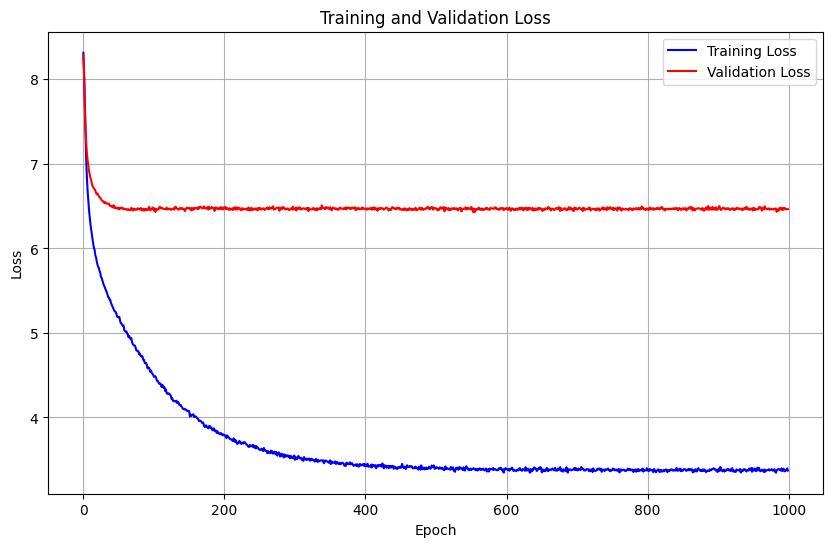

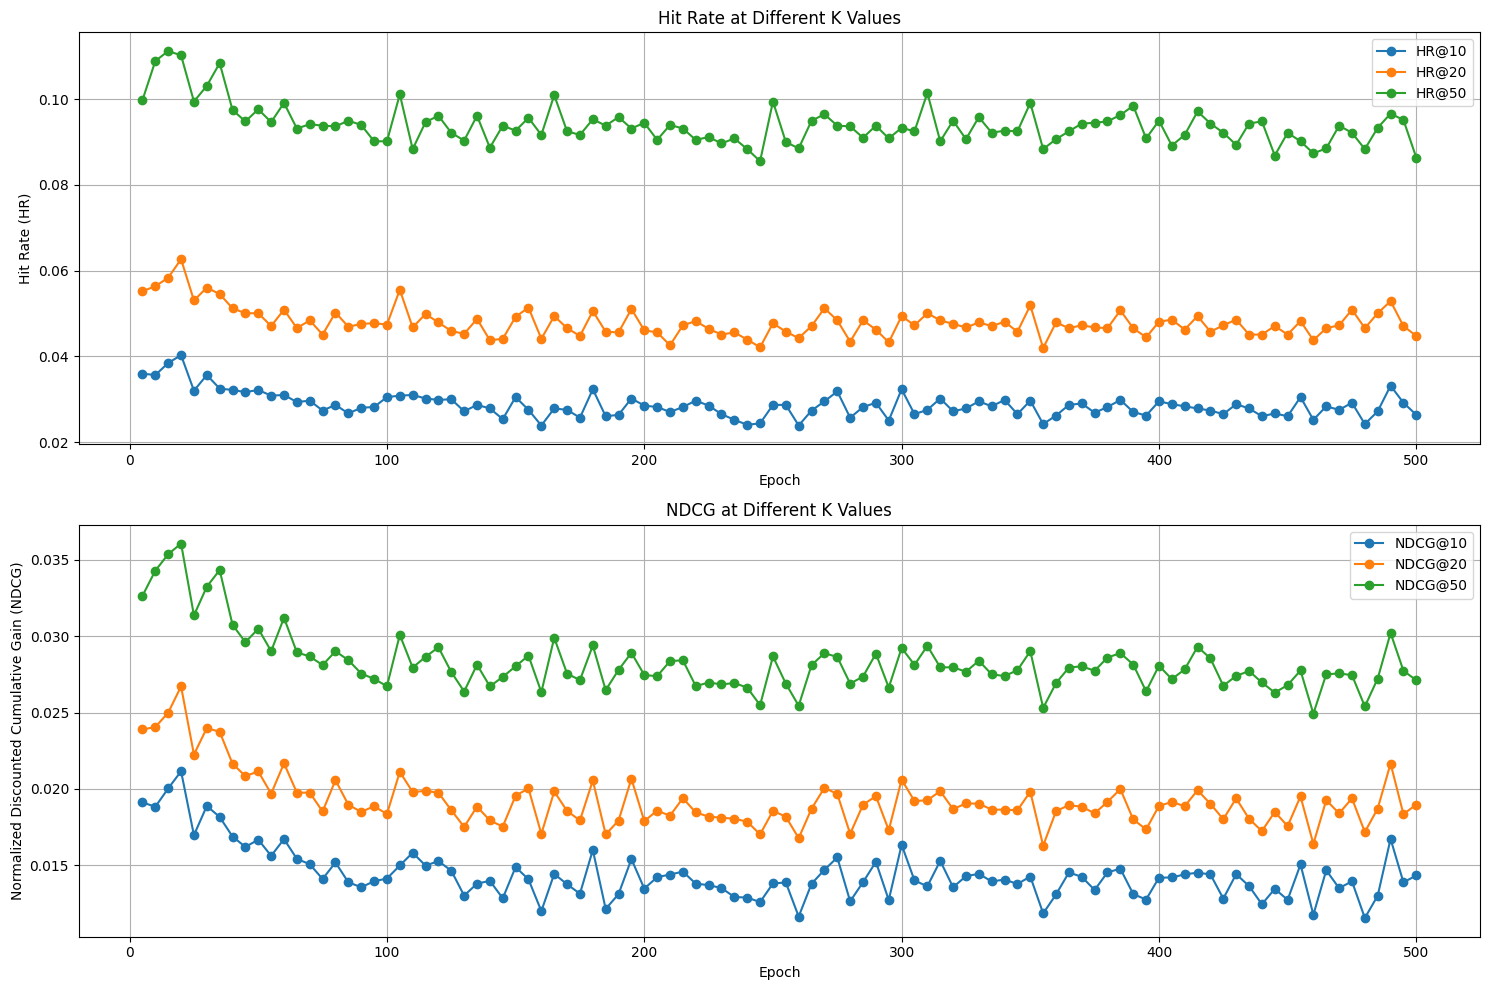

评估测试集性能...


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.14it/s]


HR@10: 0.0085, NDCG@10: 0.0040
HR@20: 0.0152, NDCG@20: 0.0057
HR@50: 0.0355, NDCG@50: 0.0096


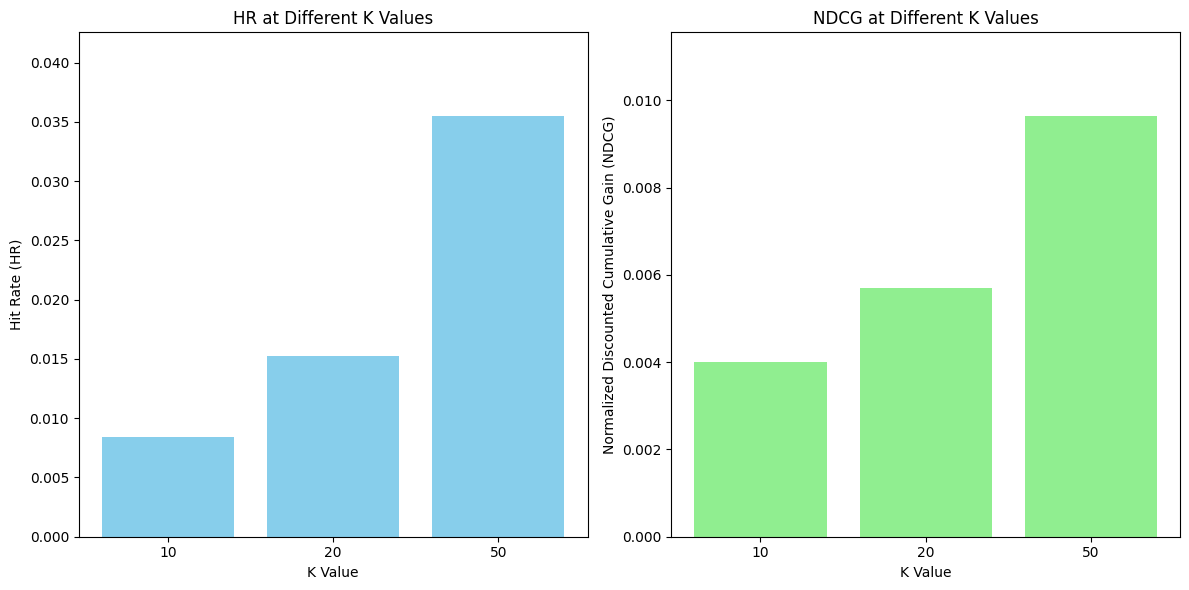

训练和评估完成!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import requests
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 胶囊网络层
class CapsuleLayer(nn.Module):
    """胶囊网络层，实现B2I动态路由算法"""
    def __init__(self, input_units, out_units, max_len, k_max=4, iterations=3):
        super(CapsuleLayer, self).__init__()
        self.input_units = input_units
        self.out_units = out_units
        self.max_len = max_len
        self.k_max = k_max
        self.iterations = iterations
        self.shared_weights = nn.Parameter(torch.randn(1, input_units, out_units))
        
    def forward(self, inputs):
        history_emb, hist_len = inputs
        batch_size = history_emb.size(0)
        k_user = torch.clamp(torch.floor(torch.log2(hist_len.float())), min=1, max=self.k_max).long()
        b_ij = torch.randn(batch_size, self.max_len, self.k_max, device=history_emb.device)
        for i in range(self.iterations):
            c_ij = F.softmax(b_ij, dim=2)
            mask = torch.arange(self.max_len, device=hist_len.device).expand(batch_size, self.max_len) >= hist_len.unsqueeze(1)
            c_ij = c_ij.masked_fill(mask.unsqueeze(2), 0)
            u_hat = torch.matmul(history_emb, self.shared_weights)
            s_j = torch.bmm(c_ij.transpose(1, 2), u_hat)
            v_j = self.squash(s_j)
            if i < self.iterations - 1:
                u_v = torch.bmm(u_hat, v_j.transpose(1, 2))
                b_ij = b_ij + u_v
        
        final_v_j = []
        for i in range(batch_size):
            final_v_j.append(v_j[i, :k_user[i], :])
        max_k = k_user.max().item()
        output = torch.zeros(batch_size, max_k, self.out_units, device=history_emb.device)
        for i in range(batch_size):
            output[i, :k_user[i], :] = final_v_j[i]
        return output, k_user
    
    def squash(self, inputs):
        norm = torch.norm(inputs, p=2, dim=2, keepdim=True)
        norm_squared = norm ** 2
        scale = norm_squared / (1 + norm_squared) / (norm + 1e-8)
        return scale * inputs

# 标签感知注意力层
class LabelAwareAttention(nn.Module):
    """标签感知注意力层，根据目标物品调整用户的多兴趣表示"""
    def __init__(self, embedding_dim, k_max=4, pow_p=1.0, dynamic_k=False):
        super(LabelAwareAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.Tanh(),
            nn.Linear(embedding_dim, 1)
        )
    
    def forward(self, inputs):
        if self.dynamic_k and len(inputs) == 3:
            user_embeddings, target_embedding, k_user = inputs
        else:
            user_embeddings, target_embedding = inputs
            k_user = torch.full((user_embeddings.size(0),), self.k_max, dtype=torch.long, device=user_embeddings.device)
        batch_max_k = k_user.max().item()
        batch_size = user_embeddings.size(0)
        processed_user_embeddings = torch.zeros(batch_size, batch_max_k, self.embedding_dim, device=user_embeddings.device)
        for i in range(batch_size):
            actual_k = k_user[i].item()
            user_interest = user_embeddings[i, :actual_k, :]
            if actual_k > batch_max_k:
                processed_user_embeddings[i] = user_interest[:batch_max_k]
            else:
                processed_user_embeddings[i, :actual_k] = user_interest[:batch_max_k]
        target_embedding = target_embedding.expand(-1, batch_max_k, -1)
        concat_vector = torch.cat([processed_user_embeddings, target_embedding], dim=2)
        similarity = self.attention(concat_vector).squeeze(2)
        mask = torch.arange(batch_max_k, device=user_embeddings.device).expand(batch_size, batch_max_k) >= k_user.unsqueeze(1)
        similarity = similarity.masked_fill(mask, -1e9)
        if self.pow_p != 1.0:
            similarity = torch.pow(similarity, self.pow_p)
        attention_weights = F.softmax(similarity, dim=1).unsqueeze(2)
        user_embedding = torch.sum(processed_user_embeddings * attention_weights, dim=1)
        return user_embedding

# MIND模型
class MIND(nn.Module):
    """Multi-Interest Network with Dynamic Routing模型"""
    def __init__(self, item_count, embedding_dim=64, k_max=4, pow_p=1.0, dynamic_k=True):
        super(MIND, self).__init__()
        self.item_count = item_count
        self.embedding_dim = embedding_dim
        self.k_max = k_max
        self.pow_p = pow_p
        self.dynamic_k = dynamic_k
        self.item_embedding = nn.Embedding(item_count, embedding_dim, padding_idx=0)
        self.capsule_layer = CapsuleLayer(embedding_dim, embedding_dim, max_len=50, k_max=k_max)
        self.label_aware_attention = LabelAwareAttention(embedding_dim, k_max=k_max, pow_p=pow_p, dynamic_k=dynamic_k)
        
    def forward(self, user_hist, target_item=None, hist_len=None):
        hist_emb = self.item_embedding(user_hist)
        multi_interests, k_user = self.capsule_layer((hist_emb, hist_len))
        if target_item is not None:
            target_emb = self.item_embedding(target_item).unsqueeze(1)
            if self.dynamic_k:
                user_embedding = self.label_aware_attention((multi_interests, target_emb, k_user))
            else:
                user_embedding = self.label_aware_attention((multi_interests, target_emb))
            return user_embedding, multi_interests
        else:
            return multi_interests
    
    def calculate_loss(self, user_embedding, target_item):
        all_item_emb = self.item_embedding.weight
        scores = torch.matmul(user_embedding, all_item_emb.transpose(0, 1))
        loss = F.cross_entropy(scores, target_item)
        return loss

# 数据集类
class UserItemDataset(Dataset):
    def __init__(self, user_hists, target_items, hist_lens):
        self.user_hists = user_hists
        self.target_items = target_items
        self.hist_lens = hist_lens
        
    def __len__(self):
        return len(self.user_hists)
    
    def __getitem__(self, idx):
        return {
            'user_hist': torch.tensor(self.user_hists[idx], dtype=torch.long),
            'target_item': torch.tensor(self.target_items[idx], dtype=torch.long),
            'hist_len': torch.tensor(self.hist_lens[idx], dtype=torch.long)
        }

# 下载并处理MovieLens数据集
def download_and_preprocess_movielens():
    # 如果数据集不存在，则下载
    data_path = 'ml-1m'
    zip_path = 'ml-1m.zip'
    ratings_file = os.path.join(data_path, 'ratings.dat')
    if not os.path.exists(data_path):
        if not os.path.exists(zip_path):
            print("下载MovieLens-1M数据集...")
            url = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
            r = requests.get(url)
            with open(zip_path, 'wb') as f:
                f.write(r.content)
        print("解压数据集...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
    print("读取和处理数据...")
    ratings = pd.read_csv(ratings_file, sep='::', 
                         engine='python', 
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
    # 过滤低评分
    ratings = ratings[ratings['rating'] >= 4]  # 只保留评分4分及以上的
    
    # 按用户分组并按时间排序
    ratings.sort_values(['user_id', 'timestamp'], inplace=True)
    # 构建用户历史序列
    user_sequences = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
    user_sequences.columns = ['user_id', 'movie_list']
    # 添加序列长度
    user_sequences['hist_len'] = user_sequences['movie_list'].apply(len)
    # 过滤序列长度太短的用户
    user_sequences = user_sequences[user_sequences['hist_len'] >= 5]
    # 分割每个用户的序列为历史序列和目标
    def split_sequence(row):
        seq = row['movie_list']
        # 最后两个物品分别作为验证和测试的目标
        return seq[:-2], seq[-2], seq[-1]
    user_sequences[['hist', 'val_target', 'test_target']] = user_sequences.apply(
        lambda row: split_sequence(row), axis=1, result_type='expand')
    # 创建训练集、验证集和测试集
    train_data = user_sequences[['hist', 'val_target', 'hist_len']].copy()
    train_data.rename(columns={'val_target': 'target'}, inplace=True)
    val_data = user_sequences[['hist', 'test_target', 'hist_len']].copy()
    val_data.rename(columns={'test_target': 'target'}, inplace=True)
    # 创建测试集：使用整个序列的最后一部分作为目标
    test_data = user_sequences[['movie_list', 'test_target', 'hist_len']].copy()
    test_data.rename(columns={'movie_list': 'hist', 'test_target': 'target'}, inplace=True)
    # 获取物品数量
    num_items = ratings['movie_id'].max() + 1  # +1 因为ID从1开始
    # 填充序列到固定长度
    max_len = 50
    def pad_sequences(sequences, max_len, pad_value=0):
        padded = []
        for seq in sequences:
            if len(seq) < max_len:
                padded.append(seq + [pad_value] * (max_len - len(seq)))
            else:
                padded.append(seq[:max_len])
        return padded
    train_user_hists = pad_sequences(train_data['hist'].tolist(), max_len)
    train_target_items = train_data['target'].tolist()
    train_hist_lens = [min(l, max_len) for l in train_data['hist_len']]
    val_user_hists = pad_sequences(val_data['hist'].tolist(), max_len)
    val_target_items = val_data['target'].tolist()
    val_hist_lens = [min(l, max_len) for l in val_data['hist_len']]
    test_user_hists = pad_sequences(test_data['hist'].tolist(), max_len)
    test_target_items = test_data['target'].tolist()
    test_hist_lens = [min(l, max_len) for l in test_data['hist_len']]
    return (train_user_hists, train_target_items, train_hist_lens,
            val_user_hists, val_target_items, val_hist_lens,
            test_user_hists, test_target_items, test_hist_lens,
            num_items)

# 训练函数
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    metrics_history = {
        'HR@10': [], 'HR@20': [], 'HR@50': [],
        'NDCG@10': [], 'NDCG@20': [], 'NDCG@50': []
    }
    best_val_loss = float('inf')
    best_metrics = None
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        #for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        for batch in train_loader:
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            optimizer.zero_grad()
            user_embedding, _ = model(user_hist, target_item, hist_len)
            loss = model.calculate_loss(user_embedding, target_item)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        # 验证阶段
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            #for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
            for batch in val_loader:
                user_hist = batch['user_hist'].to(device)
                target_item = batch['target_item'].to(device)
                hist_len = batch['hist_len'].to(device)
                user_embedding, _ = model(user_hist, target_item, hist_len)
                loss = model.calculate_loss(user_embedding, target_item)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        # 更新学习率
        scheduler.step(avg_val_loss)
        # 每10个epoch评估一次模型
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
            print(f"Evaluating model at epoch {epoch+1}...")
            metrics = evaluate_model(model, val_loader, device)
            for key, value in metrics.items():
                metrics_history[key].append(value)  
            # 保存最佳指标
            if best_metrics is None or metrics['HR@10'] > best_metrics['HR@10']:
                 best_metrics = metrics
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_mind_model.pth')
    return train_losses, val_losses, metrics_history, best_metrics

# 评估函数
def evaluate_model(model, data_loader, device, top_k_list=[10, 20, 50]):
    model.eval()
    metrics = {f'HR@{k}': [] for k in top_k_list}
    metrics.update({f'NDCG@{k}': [] for k in top_k_list})
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            user_hist = batch['user_hist'].to(device)
            target_item = batch['target_item'].to(device)
            hist_len = batch['hist_len'].to(device)
            multi_interests = model(user_hist, None, hist_len)
            all_item_emb = model.item_embedding.weight
            # 计算相似度
            similarities = torch.bmm(multi_interests, all_item_emb.transpose(0, 1).unsqueeze(0).expand(multi_interests.size(0), -1, -1))
            max_similarities, _ = torch.max(similarities, dim=1)
            # 排除历史行为中的物品
            for i in range(user_hist.size(0)):
                hist_items = user_hist[i][:hist_len[i]]
                max_similarities[i, hist_items] = -float('inf')
            # 计算指标
            for k in top_k_list:
                _, top_indices = torch.topk(max_similarities, k=k, dim=1)
                for i in range(user_hist.size(0)):
                    if target_item[i] in top_indices[i]:
                        metrics[f'HR@{k}'].append(1)
                        rank = (top_indices[i] == target_item[i]).nonzero(as_tuple=True)[0][0].item() + 1
                        metrics[f'NDCG@{k}'].append(1 / math.log2(rank + 1))
                    else:
                        metrics[f'HR@{k}'].append(0)
                        metrics[f'NDCG@{k}'].append(0)
    # 计算平均指标
    avg_metrics = {}
    for k in top_k_list:
        hr = np.mean(metrics[f'HR@{k}'])
        ndcg = np.mean(metrics[f'NDCG@{k}'])
        avg_metrics[f'HR@{k}'] = hr
        avg_metrics[f'NDCG@{k}'] = ndcg
        print(f'HR@{k}: {hr:.4f}, NDCG@{k}: {ndcg:.4f}')
    
    return avg_metrics

# 绘制损失曲线
def plot_losses(train_losses, val_losses, save_path='loss_curve.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# 绘制指标曲线
def plot_metrics(metrics_history, epochs, save_path='metrics_curve.png'):
    eval_epochs = [5 * (i+1) for i in range(len(metrics_history['HR@10']))]
    plt.figure(figsize=(15, 10))
    # 绘制HR指标对比
    plt.subplot(2, 1, 1)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'HR@{k}'], 'o-', label=f'HR@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Hit Rate (HR)')
    plt.title('Hit Rate at Different K Values')
    plt.legend()
    plt.grid(True)
    # 绘制NDCG指标
    plt.subplot(2, 1, 2)
    for k in [10, 20, 50]:
        plt.plot(eval_epochs, metrics_history[f'NDCG@{k}'], 'o-', label=f'NDCG@{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 绘制不同K值的最终指标对比
def plot_final_metrics(metrics, save_path='final_metrics.png'):
    k_values = [10, 20, 50]
    hr_values = [metrics[f'HR@{k}'] for k in k_values]
    ndcg_values = [metrics[f'NDCG@{k}'] for k in k_values]
    plt.figure(figsize=(12, 6))
    # 绘制HR指标对比
    plt.subplot(1, 2, 1)
    plt.bar([str(k) for k in k_values], hr_values, color='skyblue')
    plt.xlabel('K Value')
    plt.ylabel('Hit Rate (HR)')
    plt.title('HR at Different K Values')
    plt.ylim(0, max(hr_values) * 1.2)
    # 绘制NDCG指标对比
    plt.subplot(1, 2, 2)
    plt.bar([str(k) for k in k_values], ndcg_values, color='lightgreen')
    plt.xlabel('K Value')
    plt.ylabel('Normalized Discounted Cumulative Gain (NDCG)')
    plt.title('NDCG at Different K Values')
    plt.ylim(0, max(ndcg_values) * 1.2)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# 主函数
def main():
    # 设置参数
    embedding_dim = 64
    k_max = 5
    pow_p = 1.0
    dynamic_k = True
    batch_size = 256
    epochs = 1000
    learning_rate = 0.01
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("下载并处理MovieLens-1M数据集...")
    (train_user_hists, train_target_items, train_hist_lens,
     val_user_hists, val_target_items, val_hist_lens,
     test_user_hists, test_target_items, test_hist_lens,
     num_items) = download_and_preprocess_movielens()
    print(f"数据集信息: 物品数量={num_items}, 训练样本={len(train_user_hists)}, "
          f"验证样本={len(val_user_hists)}, 测试样本={len(test_user_hists)}")
    # 创建数据加载器
    train_dataset = UserItemDataset(train_user_hists, train_target_items, train_hist_lens)
    val_dataset = UserItemDataset(val_user_hists, val_target_items, val_hist_lens)
    test_dataset = UserItemDataset(test_user_hists, test_target_items, test_hist_lens)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # 初始化模型
    model = MIND(num_items, embedding_dim, k_max, pow_p, dynamic_k).to(device)
    # 定义优化器和学习率调度器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=10, verbose=True)
    # 训练模型
    print("开始训练模型...")
    train_losses, val_losses, metrics_history, best_metrics = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device, epochs)
    # 绘制损失曲线
    plot_losses(train_losses, val_losses, save_path='mind_loss_curve.png')
    # 绘制指标曲线
    plot_metrics(metrics_history, epochs, save_path='mind_metrics_curve.png')
    # 加载最佳模型并在测试集上评估
    model.load_state_dict(torch.load('best_mind_model.pth'))
    print("评估测试集性能...")
    test_metrics = evaluate_model(model, test_loader, device)
    # 绘制不同K值的最终指标对比
    plot_final_metrics(test_metrics, save_path='mind_final_metrics.png')
    print("训练和评估完成!")

if __name__ == "__main__":
    main()